In [15]:
# Imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

data = pd.read_csv('../data/cleaned/data_final.csv', )
data = data.drop(columns="url")
data.head()


,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,elevator,garage,storage_room,balcony,new,condition,year,agency,consumption_label,emissions_label,description
0,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.000000,2,2,3.0,exterior,True,True,True,True,False,Buen estado,2025.0,ORDUNTE Inmobiliaria,A,A,"GASTOS DE GESTIoN de 1,5 por ciento + IVA a ca..."
1,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,67.104025,2,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
2,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,44.045770,1,1,4.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
3,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,88.240759,3,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
4,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,47.888812,1,1,1.0,exterior,True,True,False,False,True,Nuevo,2025.0,Loiola,A,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac..."


In [16]:
data.info()
fetures = data.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              1230 non-null   float64
 1   zone               1230 non-null   object 
 2   neighborhood       1230 non-null   object 
 3   built_area         1230 non-null   float64
 4   usable_area        1230 non-null   float64
 5   bedrooms           1230 non-null   int64  
 6   bathrooms          1230 non-null   int64  
 7   floor              1230 non-null   float64
 8   exterior           1230 non-null   object 
 9   elevator           1230 non-null   bool   
 10  garage             1230 non-null   bool   
 11  storage_room       1230 non-null   bool   
 12  balcony            1230 non-null   bool   
 13  new                1230 non-null   bool   
 14  condition          1230 non-null   object 
 15  year               1230 non-null   float64
 16  agency             1230 

In [17]:

columnascategory = ["zone","neighborhood","exterior","condition","agency","consumption_label","emissions_label"]
data[columnascategory] = data[columnascategory].astype('category')
data["year"] = data["year"].round()
data_clustering = data.drop(columns=["description","agency" ])
data_clustering.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              1230 non-null   float64 
 1   zone               1230 non-null   category
 2   neighborhood       1230 non-null   category
 3   built_area         1230 non-null   float64 
 4   usable_area        1230 non-null   float64 
 5   bedrooms           1230 non-null   int64   
 6   bathrooms          1230 non-null   int64   
 7   floor              1230 non-null   float64 
 8   exterior           1230 non-null   category
 9   elevator           1230 non-null   bool    
 10  garage             1230 non-null   bool    
 11  storage_room       1230 non-null   bool    
 12  balcony            1230 non-null   bool    
 13  new                1230 non-null   bool    
 14  condition          1230 non-null   category
 15  year               1230 non-null   float64 
 16  consum

In [18]:
numerical_cols = ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'year']
categorical_cols = list(data_clustering.select_dtypes(include=['category']).columns)
boolean_cols = list(data_clustering.select_dtypes(include=['bool']).columns)

#VAMOS A PROBAR ELIMINANDO VARIABLES CATEGORICAS

In [19]:
data_clustering_solo_numerical_y_bol = data_clustering.drop(columns=["zone","neighborhood","condition"])
# A. Codificación One-Hot para Categóricas
data_clustering_solo_numerical_y_bol = pd.get_dummies(data_clustering_solo_numerical_y_bol, columns=["consumption_label","emissions_label","exterior"], drop_first=True)
data_clustering_solo_numerical_y_bol

,price,built_area,usable_area,bedrooms,bathrooms,floor,elevator,garage,storage_room,balcony,...,consumption_label_E,consumption_label_F,consumption_label_G,emissions_label_B,emissions_label_C,emissions_label_D,emissions_label_E,emissions_label_F,emissions_label_G,exterior_interior
0,440000.0,76.0,70.000000,2,2,3.0,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,442000.0,82.0,67.104025,2,2,1.0,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,381000.0,58.0,44.045770,1,1,4.0,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,575000.0,104.0,88.240759,3,2,1.0,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,306000.0,62.0,47.888812,1,1,1.0,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,595000.0,315.0,286.107797,4,2,4.0,False,True,False,True,...,False,False,True,False,False,False,False,True,False,False
1226,310000.0,95.0,90.000000,3,2,0.0,True,True,True,True,...,True,False,False,False,False,False,True,False,False,False
1227,198000.0,65.0,56.610709,2,1,5.0,True,False,False,True,...,False,False,True,False,False,False,False,False,True,False
1228,399000.0,109.0,105.000000,3,2,2.0,True,True,False,True,...,True,False,False,False,False,False,True,False,False,False


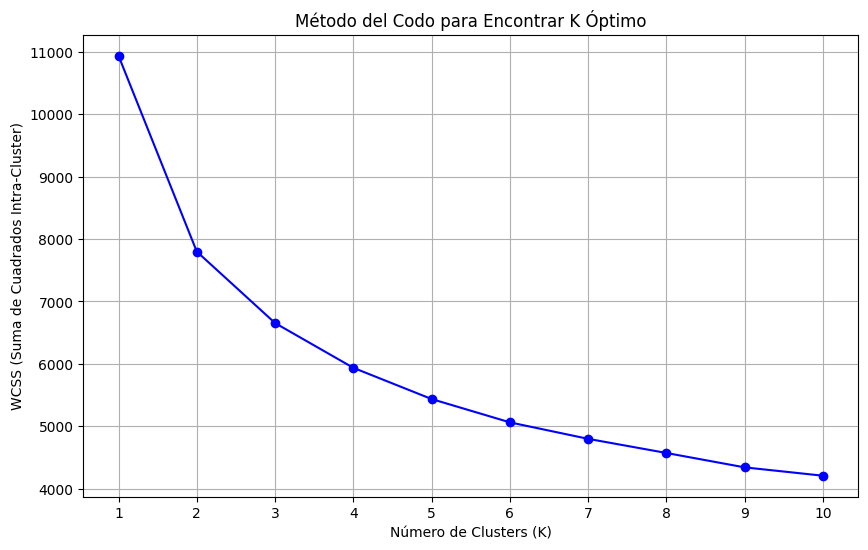

K=2: Silhouette Score = 0.3555
K=3: Silhouette Score = 0.1881
K=4: Silhouette Score = 0.1964
K=5: Silhouette Score = 0.1952
K=6: Silhouette Score = 0.1828
K=7: Silhouette Score = 0.1623
K=8: Silhouette Score = 0.1491
K=9: Silhouette Score = 0.1560
K=10: Silhouette Score = 0.1494
--- Resultado del Análisis de Silueta ---
0.06124248894640095
las variables numericas y boleanas solo = 0.35550568160304147


,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,elevator,garage,storage_room,balcony,new,condition,year,consumption_label,emissions_label,Clustersolonumybol
0,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.000000,2,2,3.0,exterior,True,True,True,True,False,Buen estado,2025.0,A,A,1
1,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,67.104025,2,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,A,A,1
2,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,44.045770,1,1,4.0,exterior,True,True,False,True,True,Nuevo,2025.0,A,A,1
3,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,88.240759,3,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,A,A,1
4,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,47.888812,1,1,1.0,exterior,True,True,False,False,True,Nuevo,2025.0,A,A,1


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
for col in boolean_cols:
    data_clustering_solo_numerical_y_bol[col] = data_clustering_solo_numerical_y_bol[col].astype(int)
    
scaler = StandardScaler()
data_clustering_solo_numerical_y_bol[numerical_cols] = scaler.fit_transform(data_clustering_solo_numerical_y_bol[numerical_cols])
X2 = data_clustering_solo_numerical_y_bol.copy()


wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2)
    wcss.append(kmeans.inertia_)

# Opcional: Visualización del Método del Codo (guarda el plot)
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='blue')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Cluster)')
plt.xticks(K_range)
plt.grid(True)
plt.show()  

#NO SE VE NADA CLARO CUAL ELEGIR, PROBAMOS SILHOUETTE


silhouette_scores = {}
K_range = range(2, 11) 


for k in K_range:
    # Entrenar K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X2)

    # Calcular el Silhouette Score
    score = silhouette_score(X2, cluster_labels)
    silhouette_scores[k] = score
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Encontrar el K con la puntuación más alta
K_optimal_silhouette = max(silhouette_scores, key=silhouette_scores.get)
best_score = silhouette_scores[K_optimal_silhouette]

print("--- Resultado del Análisis de Silueta ---")

K_OPTIMAL = 2

data_clustering_solo_numerical_y_bol.head()

kmeans_final = KMeans(n_clusters=K_OPTIMAL, init='k-means++', random_state=42, n_init=10)
data_clustering['Clustersolonumybol'] = kmeans_final.fit_predict(X2)

from sklearn.preprocessing import scale
from pyclustertend import hopkins
data_k_means_evaluation = scale(X2)
n_samples = data_k_means_evaluation.shape[0]
hopkins_score = hopkins(data_k_means_evaluation, n_samples)
print(hopkins_score) #0,05 CLUSTERS MALOS no mejora con los cambios

silhouette_avg2 = silhouette_score(X2, data_clustering["Clustersolonumybol"])

print(f"las variables numericas y boleanas solo = {silhouette_avg2}")
data_clustering.head()


ESTA CLARO QUE CON K MEANS MAL

##GAUSSIAN MIXTURE##

In [21]:
data.info()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score

# --- PASO 2: Selección y Preprocesamiento de Características ---
# Seleccionamos las características numéricas más relevantes para el clustering
features = ['price', 'built_area', 'bedrooms', 'bathrooms']
X = data[features].copy()

# El GMM es sensible a la escala, por lo que estandarizamos las características.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PASO 3: Determinación del Número Óptimo de Clústeres (k) ---
# Usamos el Criterio de Información Bayesiano (BIC) y el Criterio de Información de Akaike (AIC)
n_components = np.arange(2, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

# Calculamos BIC y AIC
bic = [m.bic(X_scaled) for m in models]
aic = [m.aic(X_scaled) for m in models]

# Graficamos BIC y AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components, bic, label='BIC', marker='o')
plt.plot(n_components, aic, label='AIC', marker='o')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Criterio de Información')
plt.title('Criterios de Información (BIC y AIC) para GMM')
plt.legend()
plt.xticks(n_components)
plt.grid(True)
#plt.savefig('bic_aic_gmm.png')
plt.close()

# --- PASO 4: Aplicación de Gaussian Mixture Model (GMM) ---
# Elegiremos el k donde los valores de BIC/AIC son más bajos. 
# Usaremos k=4 por defecto para la demostración, pero debes ajustar este valor 
# basado en la gráfica generada (bic_aic_gmm.png).
optimal_k = 4 

gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
data['cluster_gmm'] = gmm.predict(X_scaled)

# --- PASO 5: Visualización de los Clústeres ---
# Visualizamos los clústeres en las variables 'price' y 'built_area'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['built_area'], data['price'], c=data['cluster_gmm'], cmap='viridis', s=50, alpha=0.6)
plt.title(f'Clústeres de GMM (k={optimal_k})')
plt.xlabel('Área Construida')
plt.ylabel('Precio')
plt.colorbar(scatter, label='Clúster GMM')
#plt.savefig('gmm_clusters.png')
plt.close()

# Exportar resultados con los clústeres asignados
#data.to_csv('datos_con_clusters_gmm.csv', index=False)

#print(f"Se han generado dos gráficos: 'bic_aic_gmm.png' para seleccionar el k óptimo y 'gmm_clusters.png' con la visualización de los clústeres (usando k={optimal_k}).")
#print("El archivo 'datos_con_clusters_gmm.csv' contiene el DataFrame original con la nueva columna 'cluster_gmm'.")

silhouette_avg = silhouette_score(X_scaled, data['cluster_gmm']) 

print(f"El Índice de Silueta promedio es: {silhouette_avg:.4f}")

# Asegúrate de usar los datos escalados (X_scaled) y las etiquetas de cluster (df['cluster_gmm'])
ch_score = calinski_harabasz_score(X_scaled, data['cluster_gmm'])

print(f"El Índice de Calinski-Harabasz es: {ch_score:.4f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              1230 non-null   float64 
 1   zone               1230 non-null   category
 2   neighborhood       1230 non-null   category
 3   built_area         1230 non-null   float64 
 4   usable_area        1230 non-null   float64 
 5   bedrooms           1230 non-null   int64   
 6   bathrooms          1230 non-null   int64   
 7   floor              1230 non-null   float64 
 8   exterior           1230 non-null   category
 9   elevator           1230 non-null   bool    
 10  garage             1230 non-null   bool    
 11  storage_room       1230 non-null   bool    
 12  balcony            1230 non-null   bool    
 13  new                1230 non-null   bool    
 14  condition          1230 non-null   category
 15  year               1230 non-null   float64 
 16  agency

In [22]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score


lowest_bic = np.infty
best_gmm = None
optimal_k = 0
optimal_cv_type = ''
cv_types = ['spherical', 'tied', 'diag', 'full'] # Los cuatro tipos a probar

# Utilizamos el Silueta anterior (0.4032) como referencia, aunque puede ser que el mejor modelo 
# usando las features mejoradas con un k diferente a 4 lo supere.
silhouette_avg_old = silhouette_avg

print("\n--- Búsqueda en Malla: k y Tipo de Covarianza ---")
for cv_type in cv_types:
    for n_comp in n_components: 
        # Si el modelo no converge, puede lanzar un error. Usaremos try/except por robustez.
        try:
            gmm_model = GaussianMixture(n_components=n_comp, covariance_type=cv_type, random_state=42)
            gmm_model.fit(X_scaled)
            current_bic = gmm_model.bic(X_scaled)
        
            # Comprobar si es el mejor modelo BIC hasta ahora
            if current_bic < lowest_bic:
                lowest_bic = current_bic
                optimal_k = n_comp
                optimal_cv_type = cv_type
                best_gmm = gmm_model
        except Exception as e:
            # Ignorar modelos que no convergen
            print(f"Advertencia: El modelo k={n_comp}, cv='{cv_type}' falló.")
            continue

print(f"\n✅ Mejor Combinación BIC Encontrada: k={optimal_k}, Covarianza='{optimal_cv_type}'")
print(f"BIC Mínimo: {lowest_bic:.2f}")

# --- Reaplicar GMM con el MEJOR Modelo BIC y Evaluar Silueta ---
if best_gmm is not None:
    data['cluster_gmm_final'] = best_gmm.predict(X_scaled)
    silhouette_avg_final = silhouette_score(X_scaled, data['cluster_gmm_final'])
    
    print(f"\n--- Resultados del Modelo FINAL (k={optimal_k}, {optimal_cv_type}) ---")
    print(f"Índice de Silueta Promedio FINAL: {silhouette_avg_final:.4f}")

    if silhouette_avg_final > silhouette_avg_old:
        print(f"🎉 ¡Éxito! La Silueta final ({silhouette_avg_final:.4f}) superó el resultado inicial de {silhouette_avg_old:.4f}.")
    else:
        print(f"⚠️ El Silueta final ({silhouette_avg_final:.4f}) no superó el valor inicial. El modelo con menor BIC no es el más interpretable.")
else:
    print("❌ No se pudo encontrar un modelo GMM convergente. Revisa la limpieza de datos.")


--- Búsqueda en Malla: k y Tipo de Covarianza ---

✅ Mejor Combinación BIC Encontrada: k=10, Covarianza='diag'
BIC Mínimo: -11179.93

--- Resultados del Modelo FINAL (k=10, diag) ---
Índice de Silueta Promedio FINAL: 0.3518
⚠️ El Silueta final (0.3518) no superó el valor inicial. El modelo con menor BIC no es el más interpretable.


In [23]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np



best_silhouette_score = -1
optimal_k_silueta = 0

print("\n--- Búsqueda de k para MAXIMIZAR la Silueta (Modelo Interpretable) ---")
for n_comp in n_components:
    # Usamos 'full' por defecto para dar la mayor flexibilidad a las elipses
    gmm_model = GaussianMixture(n_components=n_comp, covariance_type='full', random_state=42)
    gmm_model.fit(X_scaled)
    
    # Predecir las etiquetas para calcular la Silueta
    cluster_labels = gmm_model.predict(X_scaled)
    current_silhouette = silhouette_score(X_scaled, cluster_labels)
    
    # Comprobar si este es el mejor modelo Silueta
    if current_silhouette > best_silhouette_score:
        best_silhouette_score = current_silhouette
        optimal_k_silueta = n_comp
        
    print(f"k={n_comp}: Silueta={current_silhouette:.4f}")

print(f"\n🏆 Modelo Recomendado por Silueta: k={optimal_k_silueta}")
print(f"Índice de Silueta MÁXIMO: {best_silhouette_score:.4f}")

# --- Aplicación Final ---
final_gmm = GaussianMixture(n_components=optimal_k_silueta, covariance_type='full', random_state=42)
final_gmm.fit(X_scaled)
data['cluster_gmm_final_silueta'] = final_gmm.predict(X_scaled)

if best_silhouette_score > 0.4032:
    print(f"\n🎉 ¡Felicitaciones! El Silueta MÁXIMO ({best_silhouette_score:.4f}) superó tu resultado inicial.")
else:
    print(f"\n⚠️ El Silueta MÁXIMO ({best_silhouette_score:.4f}) es inferior al resultado inicial (0.4032). Usaremos el k que dio este valor máximo.")


--- Búsqueda de k para MAXIMIZAR la Silueta (Modelo Interpretable) ---
k=2: Silueta=0.4768
k=3: Silueta=0.4019
k=4: Silueta=0.4032
k=5: Silueta=0.3960
k=6: Silueta=0.3962
k=7: Silueta=0.3779
k=8: Silueta=0.3248
k=9: Silueta=0.3182
k=10: Silueta=0.3343

🏆 Modelo Recomendado por Silueta: k=2
Índice de Silueta MÁXIMO: 0.4768

🎉 ¡Felicitaciones! El Silueta MÁXIMO (0.4768) superó tu resultado inicial.


BIRCH MODE

In [24]:
import numpy as np
import pandas as pd
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# --- 1. Configuración del Grid Search ---
# Threshold: El radio del sub-clúster. 
#   - Bajo (0.1): Muchos micro-clústeres finos.
#   - Alto (0.7): Pocos macro-clústeres gruesos.
threshold_values = [0.1, 0.2, 0.3, 0.5, 0.7]

# Branching Factor: Cuántos sub-nodos puede tener cada rama. 
#   - 50 es estándar, probamos 20 y 100 para ver si afecta la estructura del árbol.
branching_values = [20, 50, 100]

# n_clusters: El paso final de refinamiento.
#   - Probamos de 2 a 5 para ver si tus datos se agrupan mejor en más de 2 grupos.
n_clusters_values = [2, 3, 4, 5]

results = []
best_score = -1
best_params = {}
best_labels = None

print("🔄 Iniciando búsqueda de hiperparámetros para BIRCH...")

count = 0
total_iters = len(threshold_values) * len(branching_values) * len(n_clusters_values)

for t in threshold_values:
    for b in branching_values:
        for k in n_clusters_values:
            try:
                # Entrenar BIRCH
                # n_clusters=k fuerza un paso final de aglomeración para llegar a k grupos
                birch = Birch(threshold=t, branching_factor=b, n_clusters=k)
                labels = birch.fit_predict(X_scaled)
                
                # Validar que no haya generado un solo cluster por error
                unique_labels = np.unique(labels)
                if len(unique_labels) < 2:
                    continue
                
                # Calcular métricas
                sil = silhouette_score(X_scaled, labels)
                ch = calinski_harabasz_score(X_scaled, labels)
                
                # Analizar distribución (para detectar clusters gigantes)
                counts = pd.Series(labels).value_counts()
                max_ratio = counts.max() / len(labels) # % del cluster más grande
                
                results.append({
                    'threshold': t,
                    'branching': b,
                    'n_clusters': k,
                    'silhouette': sil,
                    'calinski': ch,
                    'max_cluster_ratio': max_ratio
                })
                
                # Guardar el mejor (Maximizando Silueta)
                if sil > best_score:
                    best_score = sil
                    best_params = {'threshold': t, 'branching': b, 'n_clusters': k}
                    best_labels = labels
                    print(f"  -> ✅ Nuevo mejor: k={k}, thr={t}, Silueta={sil:.4f} (Max Clúster: {max_ratio:.1%})")
                    
            except Exception as e:
                # A veces BIRCH falla si el threshold es muy bajo para la cantidad de datos
                continue

# --- 2. Resultados de la Búsqueda ---

print("\n" + "="*40)
print(f"🏆 MEJOR CONFIGURACIÓN BIRCH")
print("="*40)
print(f"Threshold (Radio): {best_params['threshold']}")
print(f"Branching Factor: {best_params['branching']}")
print(f"Número de Clústeres (k): {best_params['n_clusters']}")
print(f"Silueta: {best_score:.4f}")

# --- 3. Análisis de Distribución de Puntos (Lo que pediste) ---

if best_labels is not None:
    print("\n📊 Análisis Detallado de los Clústeres Ganadores:")
    
    # Crear DataFrame resumen
    df_dist = pd.Series(best_labels).value_counts().reset_index()
    df_dist.columns = ['Cluster_Label', 'Cantidad_Puntos']
    
    # Calcular porcentaje
    total_pts = len(X_scaled)
    df_dist['Porcentaje'] = (df_dist['Cantidad_Puntos'] / total_pts) * 100
    df_dist = df_dist.sort_values(by='Cluster_Label')
    
    print(df_dist.to_string(index=False))
    
    # Alerta de balance
    max_pct = df_dist['Porcentaje'].max()
    if max_pct > 80:
        print(f"\n⚠️ OJO: El clúster dominante tiene el {max_pct:.1f}% de los datos.")
        print("Si k=2, esto podría ser normal (fondo vs anomalía), pero revísalo.")
    elif max_pct < 60 and best_params['n_clusters'] == 2:
        print("\n✅ Balance excelente: Los grupos están bien repartidos.")

# --- 4. Top 5 Configuraciones ---
print("\nTop 5 Configuraciones probadas:")
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='silhouette', ascending=False).head(5))

🔄 Iniciando búsqueda de hiperparámetros para BIRCH...


  -> ✅ Nuevo mejor: k=2, thr=0.1, Silueta=0.4725 (Max Clúster: 72.5%)
  -> ✅ Nuevo mejor: k=2, thr=0.1, Silueta=0.5355 (Max Clúster: 80.7%)
  -> ✅ Nuevo mejor: k=2, thr=0.2, Silueta=0.6283 (Max Clúster: 94.1%)
  -> ✅ Nuevo mejor: k=2, thr=0.7, Silueta=0.6799 (Max Clúster: 98.2%)
  -> ✅ Nuevo mejor: k=2, thr=0.7, Silueta=0.6929 (Max Clúster: 97.9%)

🏆 MEJOR CONFIGURACIÓN BIRCH
Threshold (Radio): 0.7
Branching Factor: 50
Número de Clústeres (k): 2
Silueta: 0.6929

📊 Análisis Detallado de los Clústeres Ganadores:
 Cluster_Label  Cantidad_Puntos  Porcentaje
             0               26    2.113821
             1             1204   97.886179

⚠️ OJO: El clúster dominante tiene el 97.9% de los datos.
Si k=2, esto podría ser normal (fondo vs anomalía), pero revísalo.

Top 5 Configuraciones probadas:
    threshold  branching  n_clusters  silhouette    calinski  \
56        0.7        100           2    0.692856  381.343480   
52        0.7         50           2    0.692856  381.343480   


DB SCAN

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# --- Configuración de la Búsqueda ---

# 1. AJUSTE DE RANGOS:
# Si antes tenías un clúster gigante, necesitamos 'eps' más pequeños.
# Probamos pasos más finos en la zona baja (0.05 a 0.8).
eps_values = np.arange(0.05, 0.8, 0.05) 

# 2. AUMENTO DE MIN_SAMPLES:
# Aumentar esto rompe los puentes débiles entre clústeres.
min_samples_values = [10, 15, 20, 25, 30] 

best_score = -1
best_params = {'eps': None, 'min_samples': None}
best_labels = None
results = []

print("🔄 Iniciando búsqueda optimizada para evitar 'Mega-Clústeres'...")

for eps in eps_values:
    for ms in min_samples_values:
        
        # Ejecutar DBSCAN
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        
        # Estadísticas básicas
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        total_samples = len(labels)
        noise_ratio = n_noise / total_samples
        
        # --- NUEVO FILTRO: TAMAÑO DEL CLÚSTER MÁS GRANDE ---
        # Calculamos qué porcentaje de datos tiene el clúster más grande
        if n_clusters > 0:
            counts = pd.Series(labels).value_counts()
            if -1 in counts: counts = counts.drop(-1) # Ignorar ruido para este cálculo
            largest_cluster_ratio = counts.max() / total_samples
        else:
            largest_cluster_ratio = 1.0 # Si todo es ruido o un solo grupo

        # --- CRITERIOS DE FILTRADO MEJORADOS ---
        # 1. Rango de clústeres (2 a 50)
        # 2. Ruido controlado (menos del 50%, DBSCAN suele generar ruido, es normal)
        # 3. CRÍTICO: El clúster más grande NO puede tener más del 60% de los datos
        
        if (2 <= n_clusters <= 50) and (noise_ratio < 0.50) and (largest_cluster_ratio < 0.60):
            
            # Calcular Silueta (solo en core points)
            core_mask = labels != -1
            if np.sum(core_mask) > len(unique_labels): 
                sil_score = silhouette_score(X_scaled[core_mask], labels[core_mask])
                
                results.append({
                    'eps': eps, 
                    'min_samples': ms, 
                    'n_clusters': n_clusters, 
                    'noise_ratio': noise_ratio, 
                    'largest_cluster_ratio': largest_cluster_ratio,
                    'silhouette': sil_score
                })
                
                # Guardar el mejor
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {'eps': eps, 'min_samples': ms}
                    best_labels = labels
                    print(f"  -> ✅ Candidato: eps={eps:.2f}, ms={ms} | Clústers={n_clusters} | Max_Clúster={largest_cluster_ratio:.2%} | Silueta={sil_score:.4f}")

# --- Resultados ---
if best_params['eps'] is not None:
    print("\n" + "="*40)
    print(f"🏆 MEJOR CONFIGURACIÓN EQUILIBRADA")
    print("="*40)
    print(f"Epsilon: {best_params['eps']:.2f}")
    print(f"Min Samples: {best_params['min_samples']}")
    print(f"Silueta: {best_score:.4f}")
    
    # Mostrar distribución de tamaños
    final_counts = pd.Series(best_labels).value_counts().sort_index()
    print("\nDistribución por clúster (Etiqueta: Cantidad):")
    print(final_counts.to_string())
    
    # Tabla resumen top 5
    df_res = pd.DataFrame(results)
    print("\nTop 5 configuraciones:")
    print(df_res.sort_values(by='silhouette', ascending=False).head(5)[['eps', 'min_samples', 'n_clusters', 'largest_cluster_ratio', 'silhouette']])

else:
    print("\n❌ Aún no se encuentra una configuración válida.")
    print("Prueba: 1) Aumentar ligeramente el límite de ruido permitido, o 2) Revisar si las variables necesitan una transformación (Log/PowerTransform) antes de escalar.")

import pandas as pd

# Asumiendo que tus etiquetas están en 'best_labels' o 'labels'
conteos = pd.Series(best_labels).value_counts().sort_index()

print("Distribución de puntos por Clúster:")
print(conteos)
    
                                                                                 

🔄 Iniciando búsqueda optimizada para evitar 'Mega-Clústeres'...
  -> ✅ Candidato: eps=0.15, ms=10 | Clústers=10 | Max_Clúster=17.56% | Silueta=0.5106
  -> ✅ Candidato: eps=0.20, ms=20 | Clústers=7 | Max_Clúster=17.40% | Silueta=0.5303

🏆 MEJOR CONFIGURACIÓN EQUILIBRADA
Epsilon: 0.20
Min Samples: 20
Silueta: 0.5303

Distribución por clúster (Etiqueta: Cantidad):
-1    553
 0     30
 1    214
 2     76
 3    134
 4    163
 5     29
 6     31

Top 5 configuraciones:
     eps  min_samples  n_clusters  largest_cluster_ratio  silhouette
3   0.20           20           7               0.173984    0.530345
8   0.25           30           6               0.180488    0.522548
53  0.70           30           2               0.410569    0.513437
0   0.15           10          10               0.175610    0.510649
2   0.20           15           7               0.179675    0.510099
Distribución de puntos por Clúster:
-1    553
 0     30
 1    214
 2     76
 3    134
 4    163
 5     29
 6     31
Na

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# 1. Preparar datos para KNN
mask_core = best_labels != -1
X_core = X_scaled[mask_core]   # Las islas de color (entrenamiento)
y_core = best_labels[mask_core]
X_noise = X_scaled[~mask_core] # El océano gris (a predecir)

# 2. Entrenar KNN (k=1 para asignar al vecino más cercano estricto, o k=3 para suavizar)
# Usaremos k=5 para que sea una decisión "democrática" y evite errores por un solo punto
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_core, y_core)

# 3. Predecir y Crear Etiquetas Finales
noise_pred = knn.predict(X_noise)
final_labels = best_labels.copy()
final_labels[~mask_core] = noise_pred


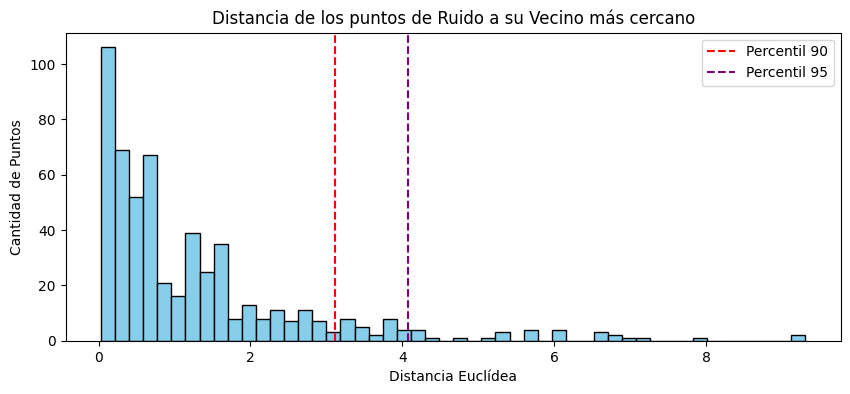

📊 Estadísticas de distancia:
count    553.000000
mean       1.284770
std        1.463242
min        0.030269
25%        0.285027
50%        0.702527
75%        1.599529
max        9.309209
dtype: float64

✂️ Aplicando corte en distancia: 4.08

Recuento Final de Clústeres (con Outliers reales aislados):
-1     28
 0     62
 1    329
 2    110
 3    191
 4    191
 5    277
 6     42
Name: count, dtype: int64


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recuperamos distancias y vecinos
# distance: qué tan lejos está el vecino
# indices: quién es el vecino
distances, indices = knn.kneighbors(X_noise)

# Nos quedamos con la distancia al vecino más cercano (columna 0)
dist_to_neighbor = distances[:, 0]

# --- PASO CRÍTICO: VER EL HISTOGRAMA PARA DECIDIR EL CORTE ---
plt.figure(figsize=(10, 4))
plt.hist(dist_to_neighbor, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(dist_to_neighbor, 90), color='r', linestyle='--', label='Percentil 90')
plt.axvline(np.percentile(dist_to_neighbor, 95), color='purple', linestyle='--', label='Percentil 95')
plt.title('Distancia de los puntos de Ruido a su Vecino más cercano')
plt.xlabel('Distancia Euclídea')
plt.ylabel('Cantidad de Puntos')
plt.legend()
plt.show()

print("📊 Estadísticas de distancia:")
print(pd.Series(dist_to_neighbor).describe())

# --- 2. APLICAR EL FILTRO (DERECHO DE ADMISIÓN) ---
# Define aquí tu límite basado en la gráfica anterior. 
# Por lo que veo en tu PCA, los puntos lejanos están MUY lejos.
# Un valor seguro suele ser el percentil 95 (descartar el 5% más lejano).
limite_distancia = np.percentile(dist_to_neighbor, 95) 

print(f"\n✂️ Aplicando corte en distancia: {limite_distancia:.2f}")

# Predecir de nuevo
noise_pred_filtered = knn.predict(X_noise)

# Donde la distancia sea mayor al límite, forzamos de nuevo a -1 (Ruido Real)
noise_pred_filtered[dist_to_neighbor > limite_distancia] = -1

# Actualizar etiquetas finales
final_labels_refined = best_labels.copy()
final_labels_refined[~mask_core] = noise_pred_filtered



# Conteo final
print("\nRecuento Final de Clústeres (con Outliers reales aislados):")
print(pd.Series(final_labels_refined).value_counts().sort_index())

📊 TABLA MAESTRA: Perfil Numérico y Booleano (Medias y %)
               Count       price  built_area  usable_area  bedrooms  bathrooms  floor     year  elevator  garage  storage_room  balcony    new
Cluster_Final                                                                                                                                 
-1                28  1528750.00      369.29       335.92      7.50       3.68   3.50  1940.54     96.43   46.43         42.86    50.00   0.00
 0                62   498903.23       93.52        80.24      1.97       2.00   3.50  1996.47     98.39   41.94         32.26    59.68  45.16
 1               329   508441.54      111.35        98.46      3.00       2.06   4.27  1975.25     98.78   44.07         39.21    60.18  16.41
 2               110   273375.41       56.47        49.59      1.00       1.00   3.73  1960.06    100.00   20.00         35.45    44.55  20.00
 3               191   269051.83       84.02        76.26      3.19       1.00   3.46

C:\Users\gonzalo.iglesias\AppData\Local\Temp\ipykernel_23420\885116186.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')


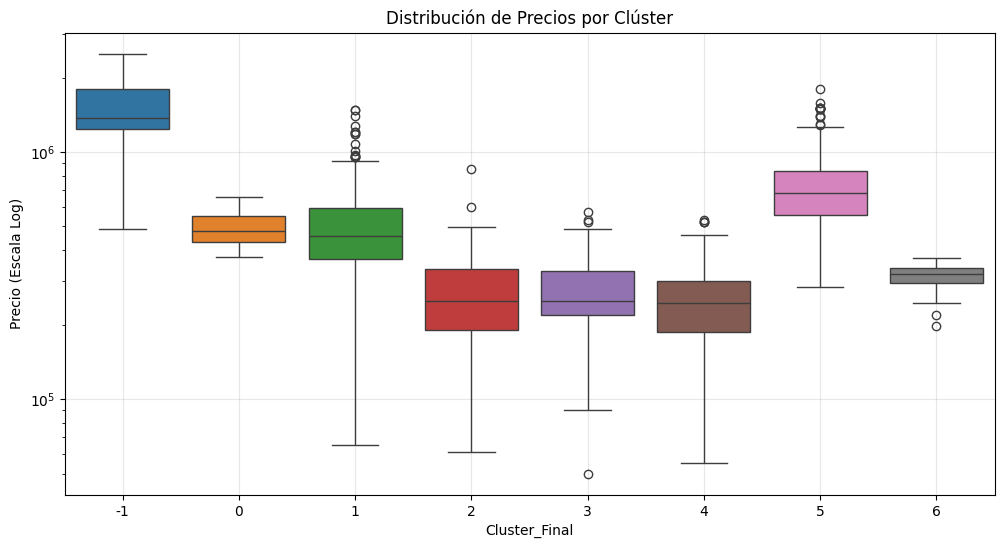

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación
df_analysis = data.copy()
df_analysis['Cluster_Final'] = final_labels_refined

# --- PARTE A: Variables Numéricas y Booleanas ---
print("📊 TABLA MAESTRA: Perfil Numérico y Booleano (Medias y %)")

# Agrupamos las numéricas (Mean + Count)
# Nota: Añadimos 'count' solo a la primera variable para no repetir columnas, 
# o lo hacemos global. Aquí lo haremos global.
summary_num = df_analysis.groupby('Cluster_Final')[numerical_cols].mean()
conteo = df_analysis['Cluster_Final'].value_counts().sort_index()
summary_num.insert(0, 'Count', conteo) # Ponemos el conteo al principio

# Agrupamos las booleanas
# TRUCO: La media de un booleano (0/1) es exactamente el % de Trues.
summary_bool = df_analysis.groupby('Cluster_Final')[boolean_cols].mean() * 100

# Unimos todo en una gran tabla
perfil_global = pd.concat([summary_num, summary_bool], axis=1)

# Redondeamos para que se lea bien
print(perfil_global.round(2).to_string())


# --- PARTE B: Variables Categóricas (Distribución %) ---
print("\n\n🎨 DISTRIBUCIÓN DE CATEGÓRICAS POR CLÚSTER")
print("="*60)

# Iteramos por cada columna categórica para ver cómo se reparte dentro de cada clúster
for col in categorical_cols:
    print(f"\n🔹 Variable: {col.upper()}")
    
    # Tabla cruzada: Filas=Cluster, Columnas=Categorías
    # normalize='index' hace que cada fila sume 1 (100%)
    cross_tab = pd.crosstab(
        df_analysis['Cluster_Final'], 
        df_analysis[col], 
        normalize='index'
    ) * 100
    
    # Mostramos solo si hay datos significativos (redondeado)
    print(cross_tab.round(1).to_string())
    print("-" * 60)

# --- PARTE C: Visualización de Precios (Tu código) ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')
plt.title('Distribución de Precios por Clúster')
# Usamos log scale si la diferencia entre el cluster -1 y el resto es gigante
plt.yscale('log') 
plt.ylabel('Precio (Escala Log)')
plt.grid(True, alpha=0.3)
plt.show()